# Build CNN to classify images in CIFAR-10 dataset
The CIFAR-10 dataset includes 32x32 images of 10 different everyday objects. These are also color images!

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

### Load data

In [2]:
# Convert PIL image to tensor
transform = transforms.ToTensor()

train_data = datasets.CIFAR10(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='../Data', train=False, download=True, transform=transform)

100.0%


Extracting ../Data\cifar-10-python.tar.gz to ../Data
Files already downloaded and verified


In [3]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

Labels:  tensor([3, 2, 5, 2, 2, 7, 4, 2, 8, 6])
Label names:  ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


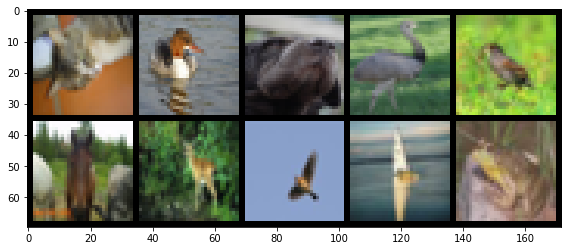

In [13]:
# Create data loaders
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10)

# Label classes
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# View a batch of images
for imgs,lbls in train_loader:
    break

print('Labels: ', lbls)
print('Label names: ', class_names)
im = make_grid(imgs, nrow=5)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1,2,0)))

### Create and train model

In [19]:
# This will be very similar to how we trained the grayscale model. The main adjustments will deal with the additional color channels

"""
How do we get 6*6*16 in_features for the first fully connected layer?
1) Start with a 32x32 image -> 30x30 images after first convolution as we lose edges
2) 30x30 -> 15x15 after first pooling layer, which applies a 2x2 kernel
3) 15x15 -> 13x13 after second conv layer
4) 13x13 -> "6.5"x"6.5" after second pooling layer, which gets rounded down to 6x6
5) 6 in_channels to conv2 x 6px per side on image after pool2 x 16 out_channels
"""

class ConvNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        # 3 color input channels, 6 (randomly selected) filters, 5x5 convolution, (default) stride of 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1)  # MNIST we used (1,6,5,1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(in_features=6*6*16, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)  # 2x2 kernel with a stride of 2
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6*6*16)  # begin flattening out
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [20]:
# Create network
model = ConvNetwork()
model

ConvNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [21]:
# How many params do we have?
for param in model.parameters():
    print(param.numel())

450
6
864
16
69120
120
10080
84
840
10


In [22]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train model
import time
start = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    # Track correct preds for train and test sets in each epoch
    trn_corr = 0
    tst_corr = 0
    # Run training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
    # Update model
        optimizer.zero_grad()  # find maxima
        loss.backward()  # backpropagate
        optimizer.step()  # update weights and biases
    # Print intermediate results
        if b%500 == 0:
            print(f'Epoch: {i} | Batch: {b} | Loss: {loss.item()}')
    # Track training loss for entire epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)
    # Evaluate test data with model without updating weights and biases
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr += batch_corr
    # Track test/val loss for entire epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

elapsed = time.time() - start
print(f'All done! Training took {round(elapsed/60, 2)} minutes.')

Epoch: 0 | Batch: 500 | Loss: 1.9273408651351929
Epoch: 0 | Batch: 1000 | Loss: 1.6408426761627197
Epoch: 0 | Batch: 1500 | Loss: 1.4399455785751343
Epoch: 0 | Batch: 2000 | Loss: 1.5214965343475342
Epoch: 0 | Batch: 2500 | Loss: 1.7372585535049438
Epoch: 0 | Batch: 3000 | Loss: 1.9383195638656616
Epoch: 0 | Batch: 3500 | Loss: 1.5109775066375732
Epoch: 0 | Batch: 4000 | Loss: 1.5496529340744019
Epoch: 0 | Batch: 4500 | Loss: 1.144040822982788
Epoch: 0 | Batch: 5000 | Loss: 0.9010842442512512
Epoch: 1 | Batch: 500 | Loss: 1.4910943508148193
Epoch: 1 | Batch: 1000 | Loss: 1.5182514190673828
Epoch: 1 | Batch: 1500 | Loss: 1.4050772190093994
Epoch: 1 | Batch: 2000 | Loss: 1.1348893642425537
Epoch: 1 | Batch: 2500 | Loss: 0.8819634318351746
Epoch: 1 | Batch: 3000 | Loss: 2.0830111503601074
Epoch: 1 | Batch: 3500 | Loss: 1.104142665863037
Epoch: 1 | Batch: 4000 | Loss: 0.8836029171943665
Epoch: 1 | Batch: 4500 | Loss: 1.9968639612197876
Epoch: 1 | Batch: 5000 | Loss: 1.0455753803253174
Epoc

In [23]:
# Save model
torch.save(model.state_dict(), 'cifar_model.pt')

### Plot loss and accuracy

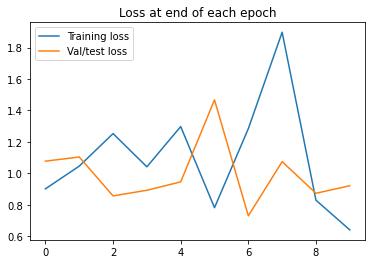

In [26]:
# Training
plt.plot([el.item() for el in train_losses], label='Training loss')
# Test/validation
plt.plot([el.item() for el in test_losses], label='Val/test loss')
plt.title('Loss at end of each epoch')
plt.legend()
# Maybe we could've trained for a few more epochs to get a bit better flattening out

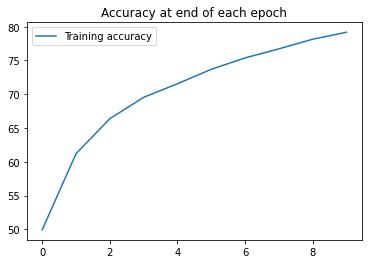

In [31]:
# Training
plt.plot([el.item()/500 for el in train_correct], label='Training accuracy')
# Test/val - I goofed this and saved it to train_correct by accident
# plt.plot([el.item()/100 for el in test_correct], label='Test/val accuracy')
plt.title('Accuracy at end of each epoch')
plt.legend()
# Perhaps we can improve the model by adding more layers to the convolutional layers, or more neurons to the fully connected layers

### Confusion matrix

In [35]:
# Create a new loader for the entire test set
test_load_all = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

# Don't update the weights
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

In [36]:
# Plot confusion matrix as heat map
arr = confusion_matrix(y_test, predicted)
cm_df = pd.DataFrame(arr, index=class_names, columns=class_names)
cm_df

,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
plane,595,59,67,30,28,11,14,26,91,79
car,26,730,8,21,1,7,14,12,29,152
bird,53,7,448,118,97,83,86,62,25,21
cat,18,14,67,483,60,152,88,58,17,43
deer,27,10,91,91,485,49,103,110,19,15
dog,10,4,60,241,43,470,56,93,10,13
frog,10,13,57,110,48,38,692,14,8,10
horse,12,2,34,69,52,54,11,720,5,41
ship,79,79,21,28,11,13,10,8,683,68
truck,24,130,12,39,9,11,13,29,33,700


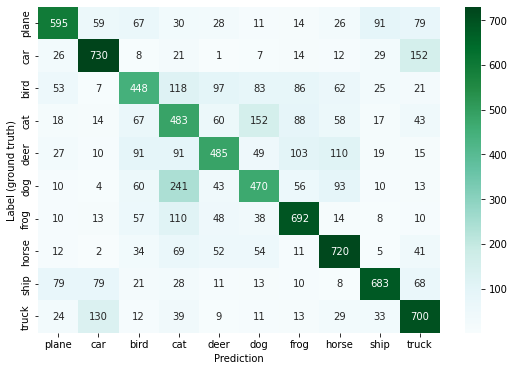

In [38]:
plt.figure(figsize=(9,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='BuGn')
plt.xlabel('Prediction')
plt.ylabel('Label (ground truth)')
plt.show()